# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

### Importing Modules

In [1]:
## IMPORTATIONS
import pandas as pd
import pandas_profiling
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
#pd.options.display.float_format = '{:.0f}'.format

import string
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as st

import re
import time

from google.colab import files
from google.colab import output

import sys
sys.executable # 'C:\\ProgramData\\Anaconda3\\python.exe'

'/usr/bin/python3'

In [2]:
%pprint

Pretty printing has been turned OFF


### Defining functions

In [0]:
def sound (choice):
  if choice == 1:
    output.eval_js('new Audio("http://bit.ly/2OyXKjh").play()')
  else:
    output.eval_js('new Audio("http://bit.ly/39bWomp").play()')

In [0]:
def info (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # number of null per row
    df_c_null = pd.DataFrame(df.isna().sum()) # number of null per column
    
    # number of rows without any 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'row_wo_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'row_wo_null'}).T
    # number of rows with all 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'row_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'row_null'}).T
    # number of mixed rows (with some null)
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'row_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'row_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null,
                          pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    info_l = pd.concat([info_nb,info_pct], sort=False)
    # total number of rows
    info_l["row_tot"] = [info_l.T['nb'].sum(), info_l.T['pct'].sum()]
    
    # number of columns without any 'null''
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_wo_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_wo_null'}).T
    # number of columns with all 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # number of mixed columns (with some null)
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null, pct_mix],
                         axis=1, sort=False).rename(index={0:'pct'})
    info_c = pd.concat([info_nb,info_pct], sort=False)
    # total number of columns
    info_c["col_tot"] = [info_c.T['nb'].sum(), info_c.T['pct'].sum()]
    
    info = pd.concat([info_l,info_c], axis=1, sort=False)
    
    return info

### Importing dataset

In [0]:
# On Google Colab: Upload a file from Google Drive via PyDrive
# Install PyDrive wrapper & import libraries (once)
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create PyDrive client (once)
auth.authenticate_user() 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID (shareable link)
file_id = '1Ua1RzJPjLAaDg9kgz3SmusmGoUO53OOx'
downloaded = drive.CreateFile({'id': file_id})
sound(2) # notifying successful authentication

In [0]:
downloaded.GetContentFile('en.openfoodfacts.org.products.csv')  
df = pd.read_csv('en.openfoodfacts.org.products.csv',
                 sep='\t', low_memory=False, encoding ='utf-8')
sound(1)

In [0]:
# df.head(1)

## Data preprocessing

### Description

In [0]:
# # Shape of the dataset
# dfshape = df.shape # (954463, 175)

In [0]:
 # my_info = info(df)
 # my_info

14 columns with no entry, no row has all the columns filled.

In [0]:
# # General description 
# desc_df = df.describe(include='all')

In [0]:
# # Types and content of the columns
# desc_type = pd.DataFrame(df.dtypes, columns=['type']).T

In [0]:
# # Null stats per column
# nb_null = (dfshape[0]-desc_df.loc["count"].T)
# pct_null = (dfshape[0]-desc_df.loc["count"].T)*100/dfshape[0]
# desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])

In [0]:
# # Concatenate general, type and null stats
# my_desc = pd.concat([desc_type, desc_null, desc_df])
# my_desc

In [0]:
# # Summary of types and content of the columns
# ser_types = df.dtypes
# for t in ser_types.unique():
#     print(t, ": ", sum(ser_types.values == t))

### Memory usage reduction

In order to facilitate the manipulation, we can specify the format of each column while loading the data in a pandas dataframe.
The precision of float16 is only 3 digit vs. 15 for float64. 

In [0]:
# # Checking the memory usage
# df.info(memory_usage='deep')

In [0]:
## Changing format of object and float64 columns
my_dtypes = {}
# object -> category (if nb unique < 10000)
for col in df.columns.values:
    if df[col].dtype == 'object' and  len(df[col].unique()) < 10000 :
        my_dtypes[col] = 'category'
# float64 -> float16
for col in df.columns.values:
    if df[col].dtype == 'float64':
        my_dtypes[col] = 'float16'

In [19]:
# Reload data 
df = pd.read_csv('en.openfoodfacts.org.products.csv', dtype=my_dtypes, 
                 sep='\t', low_memory=False, encoding ='utf-8')  # nrows=1000,
# Recheck memory usage
df.info(memory_usage='deep') # 'deep': enables more accurate memory usage report
sound(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954463 entries, 0 to 954462
Columns: 175 entries, code to carnitine_100g
dtypes: category(23), float16(117), int64(2), object(33)
memory usage: 2.2 GB


Main conclusions : 
- Description :
  954463 rows and 175 columns
  some of them categorical, 
  some of them numerical
- Memory usage reduction : 
  4.6 GB -> 2.2 GB

### Pandas Data Profiling report

In [0]:
dfcopy = df.copy(deep = True)
sound(1)

In [0]:
# Generating a Data Profiling html report via pandas_profiling
# profile = pandas_profiling.ProfileReport(dfcopy) #, check_correlation = False
# profile.to_file("OFFacts_report2_3.html")
# profile

In [0]:
# # extract rejected columns (based on correlation coeff greater than 0.9)
# rejected_variables_90 = profile.get_rejected_variables(threshold=0.9)
# len(rejected_variables_90)

Main conclusions : 

### Filtering out unimportant columns
#### 1. Non relevant columns
Some columns can immediately be classied as non useful for our project and can be dropped : 
- 5 columns concerning to the image of the product: 'image_small_url',	'image_ingredients_url',	'image_ingredients_small_url',	'image_nutrition_url'	'image_nutrition_small_url'
- 3 columns concerning the level of completion of the row: 'states', 'states_tags', 'states_en' 


In [23]:
li_col_del = ['image_small_url',	'image_ingredients_url',
              'image_ingredients_small_url',	'image_nutrition_url',
              'image_nutrition_small_url',
              'states', 'states_tags', 'states_en' ]
# Filtering out 8 non relevant columns
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(954463, 167)

#### 2. Almost empty columns

In [24]:
# Checking all 'null' columns
nbnotnulldf = pd.DataFrame((~dfcopy.isna()).sum(axis =0),
                           columns=['nb'])
nbnotnulldf.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nbnotnulldf.T.head(150)

,ingredients_that_may_be_from_palm_oil,cities,allergens_en,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,-lignoceric-acid_100g,no_nutriments,-melissic-acid_100g,ingredients_from_palm_oil,water-hardness_100g,-caproic-acid_100g,-dihomo-gamma-linolenic-acid_100g,-butyric-acid_100g,-stearic-acid_100g,-montanic-acid_100g,-myristic-acid_100g,-behenic-acid_100g,-caprylic-acid_100g,chlorophyl_100g,glycemic-index_100g,-gamma-linolenic-acid_100g,-palmitic-acid_100g,-cerotic-acid_100g,phylloquinone_100g,-arachidic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-maltose_100g,nucleotides_100g,-maltodextrins_100g,carnitine_100g,-arachidonic-acid_100g,-oleic-acid_100g,beta-glucan_100g,additives,choline_100g,serum-proteins_100g,inositol_100g,omega-9-fat_100g,casein_100g,-glucose_100g,chromium_100g,molybdenum_100g,-fructose_100g,beta-carotene_100g,taurine_100g,-eicosapentaenoic-acid_100g,silica_100g,-sucrose_100g,-docosahexaenoic-acid_100g,ph_100g,-linoleic-acid_100g,caffeine_100g,fluoride_100g,bicarbonate_100g,fruits-vegetables-nuts-dried_100g,collagen-meat-protein-ratio_100g,-alpha-linolenic-acid_100g,omega-6-fat_100g,starch_100g,-lactose_100g,carbon-footprint_100g,chloride_100g,biotin_100g,iodine_100g,polyols_100g,energy-from-fat_100g,vitamin-k_100g,selenium_100g,omega-3-fat_100g,manganese_100g,copper_100g,vitamin-e_100g,pantothenic-acid_100g,folates_100g,cocoa_100g,zinc_100g,fruits-vegetables-nuts_100g,vitamin-b9_100g,vitamin-b12_100g,phosphorus_100g,magnesium_100g,vitamin-b6_100g,vitamin-d_100g,carbon-footprint-from-meat-or-fish_100g,fruits-vegetables-nuts-estimate_100g,alcohol_100g,vitamin-b2_100g,ingredients_from_palm_oil_tags,vitamin-b1_100g,vitamin-pp_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,ingredients_that_may_be_from_palm_oil_tags,potassium_100g,first_packaging_code_geo,cities_tags,origins_tags,origins,traces,emb_codes_tags,emb_codes,traces_tags,traces_en,allergens,manufacturing_places_tags,manufacturing_places,generic_name,purchase_places,vitamin-a_100g,vitamin-c_100g,iron_100g,trans-fat_100g,cholesterol_100g,calcium_100g,labels,labels_tags,labels_en,stores,packaging_tags,packaging,additives_tags,additives_en,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_fr,serving_size,serving_quantity,quantity,fiber_100g,nova_group,main_category_en,main_category,categories_tags,categories_en,categories,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_text,additives_n,brands_tags,brands,image_url,saturated-fat_100g,sodium_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries,countries_tags,countries_en,pnns_groups_2,creator,created_datetime,last_modified_datetime,last_modified_t,created_t,url,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,3,3,3,3,3,3,4,7,9,12,14,15,15,20,20,29,30,34,36,37,38,48,55,58,66,69,84,96,101,117,128,138,197,221,222,254,273,286,287,349,377,392,402,492,528,572,757,948,1016,1315,1486,1850,2286,2341,2969,3079,4389,4497,5724,5971,6196,6666,7667,7776,8240,9069,9439,11549,11737,11941,12255,12571,24227,24281,25787,26011,39971,42868,52543,52629,60264,61952,61978,78169,78169,80681,82155,82186,90676,118066,138881,142425,142479,144226,144975,145497,159491,159515,159515,172337,178136,178139,237485,237485,265819,265819,265819,271817,271932,292258,296733,311177,345085,345085,345154,345154,345156,439597,439597,439597,439597,570120,570167,658401,709820,721199,721218,725435,739163,739214,741437,744167,876610,944390,952425,952425,952425,954115,954460,954462,954463,954463,954463,954463,954463


In [25]:
# Displaying a table with bins
mask = pd.cut(nbnotnulldf['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]            14
(0, 5]             15
(5, 10]             2
(10, 100]          19
(100, 300]         11
(300, 1000000]    106
Name: nb, dtype: int64

In [26]:
# Displaying names of columns with less than 300 entries (0.031%)
mask=pd.cut(nbnotnulldf['nb'], [-1,300])
li_col_del = mask[~mask.values.isna()].index
len(li_col_del), li_col_del

(61, Index(['ingredients_that_may_be_from_palm_oil', 'cities', 'allergens_en', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-lignoceric-acid_100g', 'no_nutriments', '-melissic-acid_100g', 'ingredients_from_palm_oil', 'water-hardness_100g', '-caproic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-butyric-acid_100g', '-stearic-acid_100g', '-montanic-acid_100g', '-myristic-acid_100g', '-behenic-acid_100g', '-caprylic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', '-gamma-linolenic-acid_100g', '-palmitic-acid_100g', '-cerotic-acid_100g', 'phylloquinone_100g', '-arachidic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', '-maltodextrins_100g', 'carnitine_100g', '-arachidonic-acid_100g', '-oleic-acid_100g', 'beta-glucan_100g', 'additives', 'choline_100g', 'serum-proteins_100g', 'inositol_100g', 'omega-9-fat_100g', 'casein_100g', '-glucose_100g', 'chromium_100g', 'molybdenum_100g

61 columns contain less than 300 entries.
Some of them (11) might nevertheless be used to complete other columns with similar content and require more investigation, or could be used on small specialized subsets of data (mineral waters, energizing drinks, meats...). They should not be dropped at first :
- 'additives',
- 'chromium_100g',
- 'molybdenum_100g',
- 'taurine_100g'
- 'silica_100g',
- 'ph_100g',
- 'caffeine_100g',
- 'fluoride_100g',
- 'bicarbonate_100g',
- 'fruits-vegetables-nuts-dried_100g',
- 'collagen-meat-protein-ratio_100g'

In [27]:
# Removing 11 columns from the "to-be-deleted" columns list 
li_col_not_del =  ['additives', 'chromium_100g', 'molybdenum_100g', 
                   'taurine_100g', 'silica_100g', 'ph_100g', 'caffeine_100g', 
                   'fluoride_100g', 'bicarbonate_100g',
                   'fruits-vegetables-nuts-dried_100g', 
                   'collagen-meat-protein-ratio_100g']
li_col_del = [i for i in li_col_del if i not in li_col_not_del]
# Filtering out 50 columns with less than 300 entries (0.021%)
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(954463, 117)

#### 3. Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'last_modified_t' vs.	'last_modified_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database.

In [0]:
def comp_df (df, col1, col2):
  mboth = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  mone = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  mcol1 = mone & ~df[col1].isna() # mask for only col1 cell filled
  mcol2 = mone & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~mone & ~mboth
  ind_both = df.index[mboth].to_list()
  ind_col1 = df.index[mcol1].to_list()
  ind_col2 = df.index[mcol2].to_list()
  ind_none = df.index[mnone].to_list()
  #ind_none = df.index[mnone].tolist()
  print("nb rows both filled: ", len(ind_both))
  print("nb rows with only", col1, "filled: ", len(ind_col1))
  print("nb rows with only", col2, "filled: ", len(ind_col2))
  print("nb rows not filled: ", len(ind_none))
  return(ind_both, ind_col1, ind_col2, ind_none)

Here is an example of the code we have used to address 'brands' and 'brands_tags' columns:

In [0]:
# Compares content of 2 columns, print info and returns indexes 
# c1 = 'brands'
# c2 = c1+'_tags'
# t_ind = comp_df(dfcopy, c1, c2)
# dfcopy.loc[(t_ind[1]+t_ind[2])[53:57],[c1, c2]]

In [0]:
# # Displaying cells when both columns are filled
# dfcopy.loc[t_ind[0], [c1,c2]].head(4)

In [0]:
# # Loop comparing the content of 'XXX_en' and 'XXX_tags' columns
# li_col = ['categories', 'labels', 'countries', 'traces', 'additives']
# for c in li_col:
#   c1 = c+'_en'
#   c2 = c+'_tags'
#   t_ind = comp_df(dfcopy, c1, c2)

In [0]:
# # Displaying 'XXX_en' and 'XXX_tags' cells
# dfcopy.loc[t_ind[0], [c1,c2]].head(4)

After examination of all the columns above-listed, we decide :
- to set the entries of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous entries ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'traces_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns; 
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep 'XXX_en' columns, as they contain useful and sometimes original data;
- to keep 'XXX' columns.

In [33]:
# Setting values of the 'XXX' column to NaN if not corresponding to other
# than NaN value in 'XXX_tags'
li_col=['packaging', 'brands', 'categories', 'origins', 'manufacturing_places',
        'labels', 'emb_codes','countries', 'traces','additives']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c, 'before:')
  t_ind = comp_df(dfcopy, c1, c2)
  dfcopy.loc[t_ind[1], [c1,c2]] = np.nan
  print('COLUMN', c, 'after:')
  t_ind = comp_df(dfcopy, c1, c2)


COLUMN packaging before:
nb rows both filled:  178134
nb rows with only packaging filled:  5
nb rows with only packaging_tags filled:  2
nb rows not filled:  776322
COLUMN packaging after:
nb rows both filled:  178134
nb rows with only packaging filled:  0
nb rows with only packaging_tags filled:  2
nb rows not filled:  776327
COLUMN brands before:
nb rows both filled:  570112
nb rows with only brands filled:  55
nb rows with only brands_tags filled:  8
nb rows not filled:  384288
COLUMN brands after:
nb rows both filled:  570112
nb rows with only brands filled:  0
nb rows with only brands_tags filled:  8
nb rows not filled:  384343
COLUMN categories before:
nb rows both filled:  345154
nb rows with only categories filled:  2
nb rows with only categories_tags filled:  0
nb rows not filled:  609307
COLUMN categories after:
nb rows both filled:  345154
nb rows with only categories filled:  0
nb rows with only categories_tags filled:  0
nb rows not filled:  609309
COLUMN origins before:
n

In [0]:
# Dropping unuseful columns
li_col_del=['created_t', 'last_modified_t','packaging_tags',
                   'brands_tags', 'categories_tags', 'origins_tags', 
                   'manufacturing_places_tags', 'labels_tags',
                   'emb_codes_tags','countries_tags', 'traces_tags',
                   'additives_tags', 'additives']
dfcopy.drop(columns = li_col_del, inplace=True)

  ### 4. Dropping inoperable rows

Certain columns are crucial to the identification of a product. We will call these columns "key columns". These are :
- code
- url
- created_datetime
These columns must be 

### Dealing with duplicates
Step by step :
- _absolute duplicates_ : keep the first
- _duplicates among key columns ('code')_ :
keep the row with less missing values, and if there're the same, keep the row with most distinct values

(One Function including all the steps "dealing_duplicates")


In [0]:
# Checking the number and extracting names of 'null' columns, if existing
col_dropna_df = df.dropna(how = 'all', axis = 1, inplace = False)
cols_null = [col for col in df.columns if col not in col_dropna_df.columns]
len(cols_null), cols_null
# Number of duplicates considering all columns or selection of crucial columns
dup_all_ser.sum(), dup_code_ser.sum(), dup_name_ser.sum(),\
dup_code_name_ser.sum(), dup_name_quant_ser.sum()
# Checking number and extracting names of columns with more than 2.5% missing values ('null')
cols_miss_val = df_null[df_null['pct_non_null']<2.5].index
len(cols_miss_val), cols_miss_val

dfcopy.dropna(subset=[how='any','created_t', 'last_modified_t'],inplace=True)

# Eliminating rows with crucial data missing
# (no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape
# Eliminating columns with more than 2.5% missing values
#(no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape

In [0]:
# Calculating the EAN check digit for 13-digit numbers
def calc_check_digit(number):
    first = 
    last = 
    if len(number) not in (14, 13, 12, 8):
        return False
    else:
        return str((10 - sum((3, 1)[i % 2] * int(n)
                         for i, n in enumerate(reversed(number)))) % 10)
        
# Rows with erroneous barcode
number of digits
code_len_tab = df["code"].apply(len).values
nb_dig_code_df = pd.DataFrame(np.histogram(code_len_tab, bins = max(code_len_tab)))
nb_dig_code_df.

        
def validate(number):
    """Check if the number provided is a valid EAN-13. This checks the length
    and the check bit but does not check whether a known GS1 Prefix and
    company identifier are referenced."""
    number = compact(number)
    if not isdigits(number):
        raise InvalidFormat()
    if len(number) not in (14, 13, 12, 8):
        raise InvalidLength()
    if calc_check_digit(number[:-1]) != number[-1]:
        raise InvalidChecksum()
    return number


np.nansum(dup_key_df.groupby(by=['code','product_name','quantity','brands']).count()["url"].values)
New column 'quantity_norm' with normalized quantities (put all in g, numeric)
df_clean["quantity"]
df.replace(to_replace=r'g', value='', regex=True)
dup_key_df.groupby(by=['code','product_name','quantity','brands']).count().shape#
dup_code_ser = df.duplicated(subset=['code'], keep='first')
dup_name_ser = df.duplicated(subset=['product_name'], keep='first')
dup_code_name_ser = df.duplicated(subset=['code','product_name'], keep='first')
dup_name_quant_ser = df.duplicated(subset=['quantity','product_name'], keep='first')

In [0]:
def dealing_duplicates (df, key_cols):
  df_clean = df.copy(deep = True)
  # Delete 'null' rows, if existing
  df_clean.dropna(how = 'all', axis = 0, inplace = True)
  # Delete duplicated rows (all columns)
  dup_all_ser = df_clean.duplicated(subset=None, keep='first')
  df_clean.drop(index = df_clean[dup_all_ser.values == True].index, inplace=True)
  # Dealing with duplicated rows (among key columns)
  dup_key_df = df_clean[df_clean.duplicated(subset=key_cols,
                                            keep=False).values]
  # ranging indexes by decreasing amount of 'nan's then by distinct values
  li_ind = pd.DataFrame({'n_rens' : df.isna().T.sum().values,
                'n_dist' : len(df.iloc[1].T.unique())},
                              index = ech.index.values)\
          .sort_values(by=["n_rens", "n_dist"], ascending = True).index
  df_comb = df.loc[li_ind[0]:li_ind[0]]
  # combine the rows in appropriate order
  for ind in li_ind:
      df_comb = df_comb.reset_index().combine_first(df.loc[ind:ind]\
                       .reset_index()).set_index('index').rename_axis(None)
  # replaces the unique row and drop useless rows
  df_clean.update(df_comb, overwrite=True)
  df_clean.drop(li_ind[1:], inplace = True)
  return df_clean

nb rows both filled:  271817
nb rows with only serving_size filled:  0
nb rows with only serving_quantity filled:  115
nb rows not filled:  682531


,serving_size,serving_quantity
45,28 g (1 ONZ),28
46,28 g (0.25 cup),28


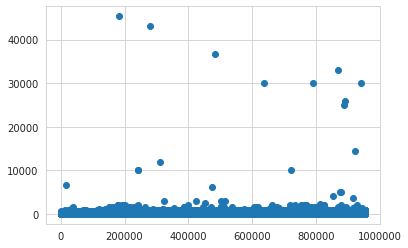

- We keep serving_quantity, as it contains data already

,serving_quantity,serving_size,quantity
1081,0,2 gellules,90 capsules
1168,0,100,1 kg
1790,0,1Banana,NaN
2988,0,1Slice,NaN
3019,0,58,50 g
...,...,...,...
952832,0,50 Grams,NaN
953098,0,10,200 ml
953574,0,"1,25",25g
954062,0,4,1000g


{'pnns_groups_1': 'cat_nutri_inf', 'pnns_groups_2': 'cat_nutri_inf'}

178134 7
both columns filled:                    packaging       packaging_tags
17      barquette,plastique  barquette,plastique
135         bocal,plastique      bocal,plastique
138               plastique            plastique
290        carton,plastique     carton,plastique
291        plastique,carton     plastique,carton
...                     ...                  ...
954409     carton,plastique     carton,plastique
954423            plastique            plastique
954429       műanyag,zacskó       műanyag,zacsko
954434            bouteille            bouteille
954438            Plastique            plastique

[178134 rows x 2 columns]
one of them filled:  7
col1 filled:  [178139]
col2 filled:  [178136]


In [0]:
# # Number of 'null' rows and columns in the dataset
# info_df = info(df)
# pd.options.display.float_format = '{:.0f}'.format
# info_df.head()

Main conclusions : 

NameError: ignored

### Cleaning of key columns

In [0]:
df_clean = df.copy(deep = True)

In [0]:
# Check nb of duplicated rows

def check_duplicates(df, key_cols) : 
  dup_key_df = df_clean[df_clean.duplicated(subset=key_cols,
                                            keep=False).values]
  dup_key_df = dup_key_df.fillna('missing').loc[:,key_cols]\
                         .reset_index().groupby(by=key_cols).count()
  # NB : necessary to use fillna because groupby doesn't consider nan as a value
  return  dup_key_df.shape[0], dup_key_df.sum().values[0]

In [0]:
key_cols = ['code','product_name','quantity','brands']
#key_cols = list(df.columns)
dup_t = check_duplicates(df, key_cols)
print("nb of groups of duplicates : ", dup_t)

(117, 234)

In [0]:
df_cleanbis = dealing_duplicates (df, ['code'])

In [0]:
df_cleanbis.shape

(954302, 175)

In [0]:
# 2 éliminer les entrées qui n'ont pas de code, ou pas de nom de produit

### Reconstructing/fixing the columns

__Main conclusions__ :
 - 14 columns with no data
 - 78 columns with very few data (less than 2.5 %)
 - 0 row with no data
 -  rows with crucial data missing

#### Dealing with missing values

### Outliers

#### -> dealing with outliers

### Rescaling data

In [0]:
# separating numerical data from object data
# num_df = df.select_dtypes(include="number")
# obj_df = df.select_dtypes(include="object")
# df.shape, num_df.shape, obj_df.shape

In [0]:
# # no need for the datetime columns
# # cols = [c for c in df.columns if c.lower()[-9:] != '_datetime' and c.lower()[-2:] != '_t']
# cols = [c for c in df.columns if c.lower()[-5:] == '_100g']
# cols.append('code')
# df = df[cols]

# # eliminate null values
# df = df[(df['energy_100g'] != 0) & (df['nutrition-score-fr_100g'] != 0)]

# # we keep only column 70% filled
# thresh = len(df) * .3
# df.dropna(thresh = thresh, axis = 1, inplace = True)

# df = df.fillna(0)

# df = df.round(5)